# PyTorch RGB CNN model

In this notebook, we build a convolutional neural network (CNN) classifier for the CIFAR-10 dataset using PyTorch's `nn.Sequential` module with full RGB color images.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Package imports
from cifar10_tools.pytorch.evaluation import evaluate_model
from cifar10_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)
from cifar10_tools.pytorch.training import train_model

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Hyperparameters

In [2]:
batch_size = 10000 # Training images come in 5 batches of 10,000
learning_rate = 1e-3
epochs = 100
print_every = 10 # Print training progress every n epochs

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 1. Load and preprocess CIFAR-10 data

CIFAR-10 contains 32x32 color images (3 channels) across 10 classes. We use the full RGB images for this demonstration.

### 1.1. Load datasets

In [3]:
# Make sure data directory exists
data_dir = Path('../data/pytorch/cifar10')
data_dir.mkdir(parents=True, exist_ok=True)

# Data preprocessing: keep RGB channels, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=False,
    transform=transform
)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Number of classes: {len(class_names)}')

Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 10


### 1.2. Visualize sample images

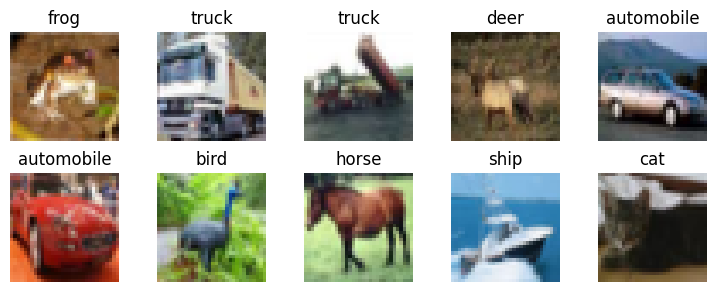

In [4]:
# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(train_dataset, class_names)
plt.show()

### 1.3. Create training, validation and testing tensors

In [5]:
# Reshape and preload entire dataset to device for faster training
X_train_full = torch.stack([img for img, _ in train_dataset]).to(device)
y_train_full = torch.tensor([label for _, label in train_dataset]).to(device)

X_test = torch.stack([img for img, _ in test_dataset]).to(device)
y_test = torch.tensor([label for _, label in test_dataset]).to(device)

# Split training data into train and validation sets (80/20 split)
n_train = int(0.8 * len(X_train_full))
indices = torch.randperm(len(X_train_full))

X_train = X_train_full[indices[:n_train]]
y_train = y_train_full[indices[:n_train]]
X_val = X_train_full[indices[n_train:]]
y_val = y_train_full[indices[n_train:]]

print(f'X_train shape: {X_train.shape}, device: {X_train.device}')
print(f'y_train shape: {y_train.shape}, device: {y_train.device}')
print(f'X_val shape: {X_val.shape}, device: {X_val.device}')
print(f'y_val shape: {y_val.shape}, device: {y_val.device}')
print(f'X_test shape: {X_test.shape}, device: {X_test.device}')
print(f'y_test shape: {y_test.shape}, device: {y_test.device}')

X_train shape: torch.Size([40000, 3, 32, 32]), device: cuda:0
y_train shape: torch.Size([40000]), device: cuda:0
X_val shape: torch.Size([10000, 3, 32, 32]), device: cuda:0
y_val shape: torch.Size([10000]), device: cuda:0
X_test shape: torch.Size([10000, 3, 32, 32]), device: cuda:0
y_test shape: torch.Size([10000]), device: cuda:0


### 1.4. Create `DataLoader()` objects

In [6]:
# Create TensorDatasets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(
    train_tensor_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_tensor_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f'Training batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 4
Validation batches: 1
Test batches: 1


## 2. Build CNN classifier with nn.Sequential

We build a convolutional neural network using `nn.Sequential`. The CNN uses convolutional layers to extract spatial features from the 32x32x3 RGB images before classification.

### 2.1. Define model architecture

In [7]:
# Input: 3 x 32 x 32 (RGB)
num_classes = 10

model = nn.Sequential(

    # Conv block 1: 3 -> 32 channels, 32x32 -> 16x16
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 2: 32 -> 64 channels, 16x16 -> 8x8
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Conv block 3: 64 -> 128 channels, 8x8 -> 4x4
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.5),
    
    # Classifier
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, num_classes)
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.5, inplace=False)
  (16): Conv2d(64, 128, kernel_size=(3, 3), strid

### 2.2. Define loss function and optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 2.3. Train model

In [9]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    print_every=print_every
)

Epoch 1/100 - loss: 2.3178 - accuracy: 11.35% - val_loss: 2.3029 - val_accuracy: 10.12%
Epoch 10/100 - loss: 1.5773 - accuracy: 39.92% - val_loss: 2.7295 - val_accuracy: 18.61%
Epoch 20/100 - loss: 1.2705 - accuracy: 53.78% - val_loss: 1.8943 - val_accuracy: 41.99%
Epoch 30/100 - loss: 1.0717 - accuracy: 62.60% - val_loss: 1.7092 - val_accuracy: 50.61%
Epoch 40/100 - loss: 0.9383 - accuracy: 67.35% - val_loss: 1.0757 - val_accuracy: 63.28%
Epoch 50/100 - loss: 0.8383 - accuracy: 71.19% - val_loss: 0.8599 - val_accuracy: 70.00%
Epoch 60/100 - loss: 0.7627 - accuracy: 73.90% - val_loss: 0.8129 - val_accuracy: 71.60%
Epoch 70/100 - loss: 0.7099 - accuracy: 75.90% - val_loss: 0.7113 - val_accuracy: 75.61%
Epoch 80/100 - loss: 0.6651 - accuracy: 77.28% - val_loss: 0.6708 - val_accuracy: 76.53%
Epoch 90/100 - loss: 0.6317 - accuracy: 78.58% - val_loss: 0.7054 - val_accuracy: 76.45%
Epoch 100/100 - loss: 0.5952 - accuracy: 79.63% - val_loss: 0.6251 - val_accuracy: 78.63%

Training complete.
C

### 2.4. Learning curves

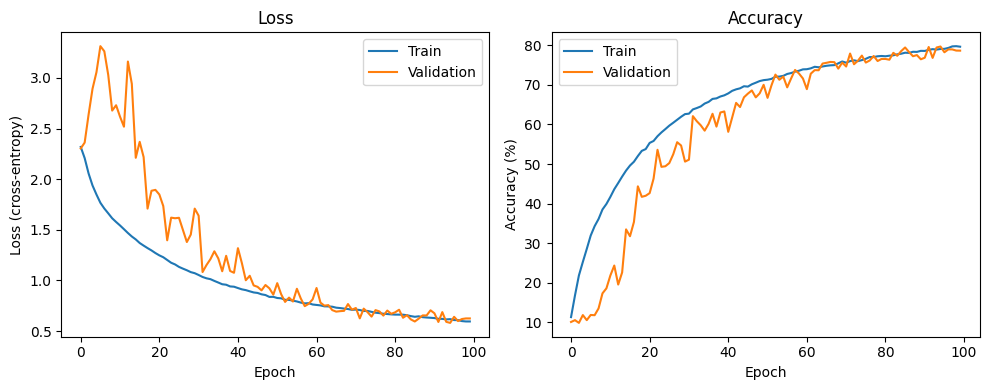

In [10]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [11]:
test_accuracy, predictions, true_labels = evaluate_model(model, test_loader)
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 78.18%


### 3.2. Per-class accuracy

In [12]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 71.50%
automobile  : 87.10%
bird        : 58.20%
cat         : 56.40%
deer        : 80.50%
dog         : 70.20%
frog        : 96.00%
horse       : 79.50%
ship        : 92.20%
truck       : 90.20%


### 3.3. Confusion matrix

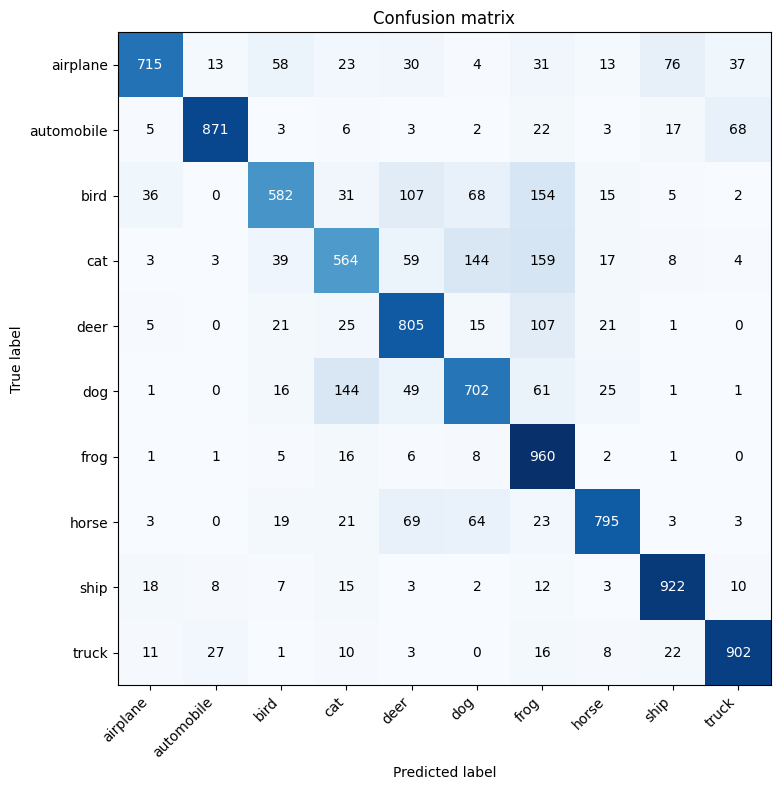

In [13]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.4. Predicted class probability distributions

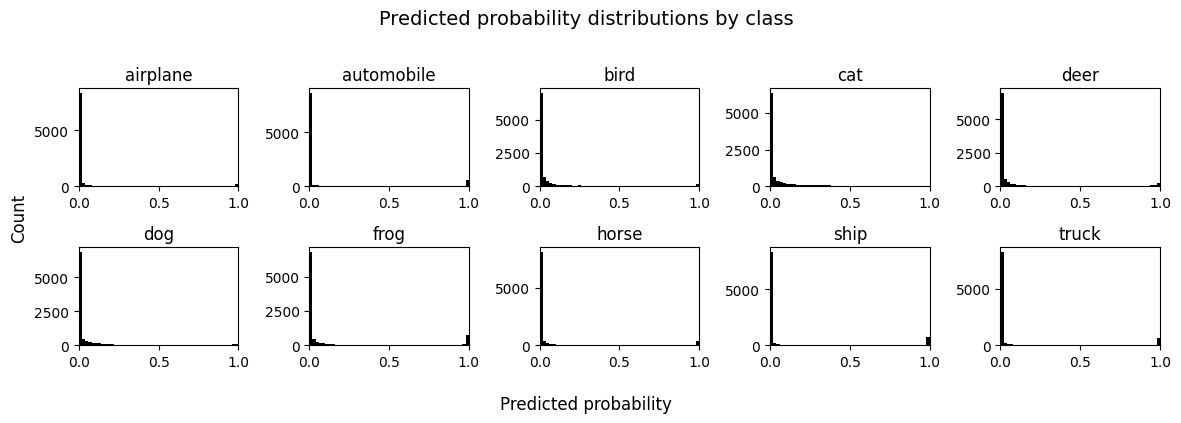

In [14]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.5. Evaluation curves

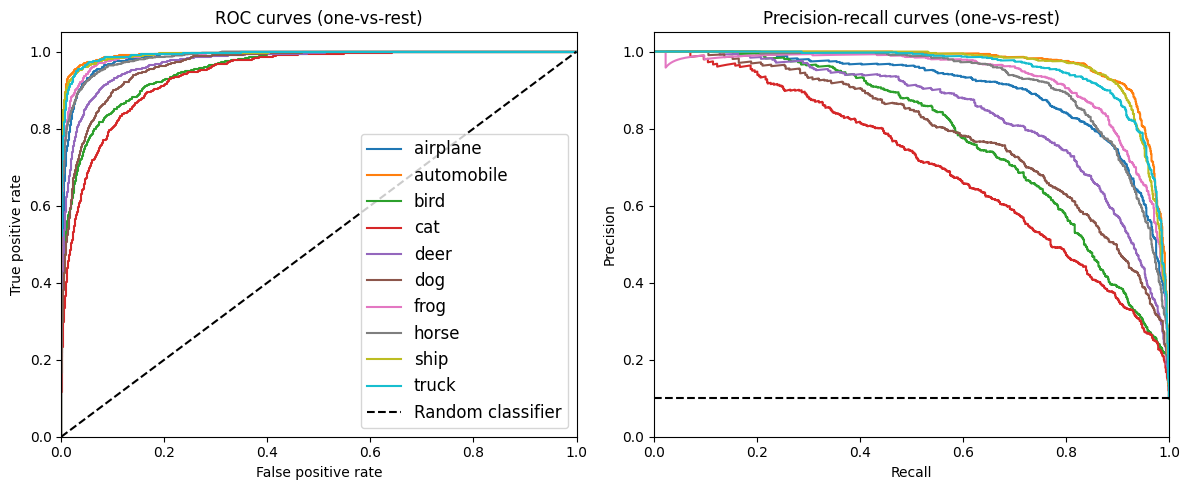

In [15]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [ ]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'rgb_cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')